# AN Plots
This notebook is used to collect some of the code used to produce the plots particularly for the analysis note AN-22-133.

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
import mplhep as hep
import warnings
from plot_utils import *
import fill_utils

warnings.filterwarnings('ignore')
hep.style.use("CMS")
plt.style.use(hep.style.CMS)
matplotlib.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.dpi'] = 70
matplotlib.rcParams['figure.facecolor'] = 'white'

## Notebook Parameters
The following couple cells define the input and output directories, and load in the desired .pkl files into the `plots` nested dictionary.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>

In [2]:
# parameters
output_label = '/home/submit/lavezzo/public_html/SUEP/analysis/ABCDsystematics/'
AN_label = '/home/submit/lavezzo/SUEP/AN-22-133/images/offline/{}.pdf'
saveToAN = True  # control whether to save to AN directory
file_ext = '.pdf'

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (sample) x (plot label) <br>
The `loader` function in `plot_utils.py` automatically merges all the QCD HT and QCD pT bins into one sample ('QCD_HT' and 'QCD_Pt'), applies the lumis, and excludes some of the low QCD bins.<br>

In [3]:
# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# This part is meant to be flxeible, depending on what you want to import
# dimensions: (sample) x (plot label)

# input .pkl files
plotDir = '/data/submit/{}/SUEP/outputs/'.format(os.environ['USER'])
infile_names = glob.glob(plotDir+'*.pkl')

# generate list of files that you want to merge histograms for
offline_files_SUEP_2018 = [f for f in infile_names if "Impacts_2018.pkl" in f and ('GluGlu' in f and 'generic' in f)]
offline_files_SUEP_2017 = [f for f in infile_names if "Impacts_2017.pkl" in f and ('GluGlu' in f and 'generic' in f)]
offline_files_SUEP_2016 = [f for f in infile_names if "Impacts_2016.pkl" in f and ('GluGlu' in f and 'generic' in f)]
offline_files_SUEP_2016apv = [f for f in infile_names if "Impacts_2016apv.pkl" in f and ('GluGlu' in f and 'generic' in f and 'mPhi3' in f)]

offline_files_2018 = [f for f in infile_names if "March2023.pkl" in f and ('20UL18' in f)]
offline_files_2017 = [f for f in infile_names if "March2023.pkl" in f and ('20UL17' in f)]
offline_files_2016 = [f for f in infile_names if "March2023.pkl" in f and ('20UL16' in f)]

offline_files_2018 += [f for f in infile_names if "unblind.pkl" in f and ('20UL18' in f or 'Run2018' in f) and "JetHT+Run2018D-UL2018_MiniAODv2-v1+MINIAOD" not in f]
offline_files_2017 += [f for f in infile_names if "unblind.pkl" in f and ('20UL17' in f or 'Run2017' in f)]
offline_files_2016 += [f for f in infile_names if "unblind.pkl" in f and ('20UL16' in f or 'Run2016' in f)]

In [4]:
# merge the histograms, apply lumis, exclude low HT bins
plots_SUEP_2018 = loader(offline_files_SUEP_2018, year='2018', exclude_low_bins=True)
plots_SUEP_2017 = loader(offline_files_SUEP_2017, year='2017', exclude_low_bins=True)
plots_SUEP_2016 = loader(offline_files_SUEP_2016, year='2016', exclude_low_bins=True)
plots_SUEP_2016apv = loader(offline_files_SUEP_2016apv, year='2016_apv', exclude_low_bins=True)

plots_2018 = loader(offline_files_2018, auto_lumi=True, exclude_low_bins=True)
plots_2017 = loader(offline_files_2017, auto_lumi=True, exclude_low_bins=True)
plots_2016 = loader(offline_files_2016, auto_lumi=True, exclude_low_bins=True)

In [5]:
# put everything in one dictionary
plots = {}

def applyNormalizationToSUEPSamples(files, plots_SUEP):   
    output = {}
    for file, sample in zip(files, plots_SUEP.keys()):
        file = file.split("/")[-1].split("13TeV")[0]+'13TeV-pythia8'
        xsection = fill_utils.getXSection(file, '2018_SUEP')
        output[sample] = fill_utils.apply_normalization(plots_SUEP[sample], xsection)
    return output
    

# apply xsection and filter efficiency to SUEP here
plots_SUEP_2018 = applyNormalizationToSUEPSamples(offline_files_SUEP_2018, plots_SUEP_2018)
plots_SUEP_2017 = applyNormalizationToSUEPSamples(offline_files_SUEP_2017, plots_SUEP_2017)
plots_SUEP_2016 = applyNormalizationToSUEPSamples(offline_files_SUEP_2016, plots_SUEP_2016)
plots_SUEP_2016apv = applyNormalizationToSUEPSamples(offline_files_SUEP_2016apv, plots_SUEP_2016apv)

for key in plots_SUEP_2018.keys(): plots[key+"_2018"] = plots_SUEP_2018[key]
for key in plots_SUEP_2017.keys(): plots[key+"_2017"] = plots_SUEP_2017[key]
for key in plots_SUEP_2016.keys(): 
    plots[key+"_2016"] = {}
    for plot in plots_SUEP_2016[key].keys():
        plots[key+"_2016"][plot] = plots_SUEP_2016[key][plot] + plots_SUEP_2016apv[key][plot]
for key in plots_2018.keys(): plots[key+"_2018"] = plots_2018[key]
for key in plots_2017.keys(): plots[key+"_2017"] = plots_2017[key]
for key in plots_2016.keys(): plots[key+"_2016"] = plots_2016[key]

In [6]:
# add different MC processes together
def addMCSamples(year):
    year = str(year)
    plots['MC_'+year] = {}
    for key in plots['QCD_HT_'+year].keys():
        plots['MC_'+year][key] = plots['QCD_HT_'+year][key].copy() + plots['TTJets_'+year][key].copy()

def addYears(sample):
    plots['{}_all'.format(sample)] = {}
    for i, year in enumerate([2018, 2017, 2016]):
        for key in plots['{}_{}'.format(sample, year)].keys():
            if i == 0: plots['{}_all'.format(sample)][key] = plots['{}_{}'.format(sample, year)][key].copy()
            else: plots['{}_all'.format(sample)][key] += plots['{}_{}'.format(sample, year)][key].copy()
        
for year in [2018, 2017, 2016]: addMCSamples(year)
addYears('MC')
addYears('data')

These are all the samples loaded.

In [7]:
keys = list(plots.keys())
keys.sort()
for k in keys: print(k)

1000to1500_2016
1000to1500_2017
1000to1500_2018
1500to2000_2016
1500to2000_2017
1500to2000_2018
2000toInf_2016
2000toInf_2017
2000toInf_2018
200to300_2016
200to300_2017
200to300_2018
300to500_2016
300to500_2017
300to500_2018
500to700_2016
500to700_2017
500to700_2018
700to1000_2016
700to1000_2017
MC_2016
MC_2017
MC_2018
MC_all
QCD_HT_2016
QCD_HT_2017
QCD_HT_2018
TTJets_2016
TTJets_2017
TTJets_2018
TTJets_HT-1200to2500_2016
TTJets_HT-1200to2500_2017
TTJets_HT-1200to2500_2018
TTJets_HT-2500toInf_2016
TTJets_HT-2500toInf_2017
TTJets_HT-2500toInf_2018
TTJets_HT-600to800_2016
TTJets_HT-600to800_2017
TTJets_HT-600to800_2018
TTJets_HT-800to1200_2016
TTJets_HT-800to1200_2017
TTJets_HT-800to1200_2018
data_2016
data_2017
data_2018
data_A_2018
data_B-ver1_HIPM_UL2016_MiniAODv2-v2+MINIAOD_unblind_2016
data_B-ver2_HIPM_UL2016_MiniAODv2-v2+MINIAOD_unblind_2016
data_B_2017
data_B_2018
data_C-HIPM_UL2016_MiniAODv2-v2+MINIAOD_unblind_2016
data_C_2017
data_C_2018
data_D-HIPM_UL2016_MiniAODv2-v2+MINIAOD_u

## Ch. 4 Event Selection

### 1D Comparison - HT

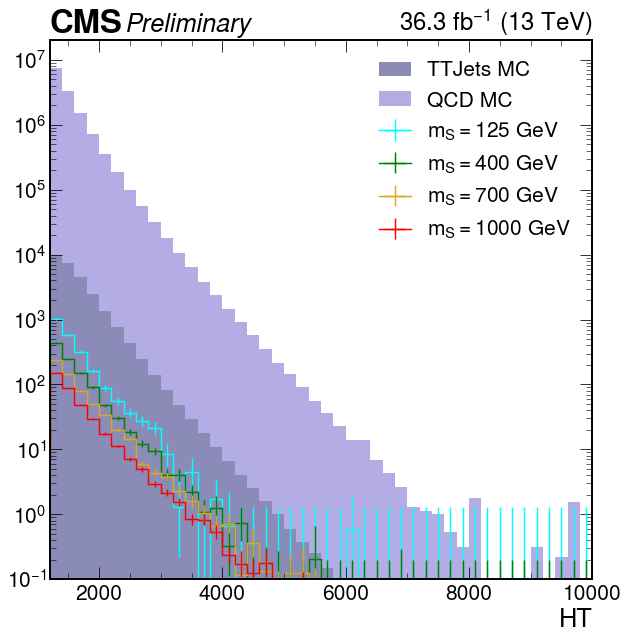

In [20]:
plot_label = 'ht_Cluster70'
year = '2016'

temp = '3.0'
mPhi = '3.0'
decay = 'generic'
samples = ['TTJets_'+year, 'QCD_HT_'+year, 
            'mS125_T'+temp+'_mPhi'+mPhi+'_'+decay+'_'+year,
            'mS400_T'+temp+'_mPhi'+mPhi+'_'+decay+'_'+year,
            'mS700_T'+temp+'_mPhi'+mPhi+'_'+decay+'_'+year,
            'mS1000_T'+temp+'_mPhi'+mPhi+'_'+decay+'_'+year]
labels = ['TTJets MC', 'QCD MC',
          r'$m_{S}=125$ GeV',r'$m_{S}=400$ GeV',r'$m_{S}=700$ GeV',r'$m_{S}=1000$ GeV']
density = False

hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year))
hBkg, hSignal, cSignal = [], [], []
lBkg, lSignal, cBkg = [], [], []
for label, sample in zip(labels, samples):
    if sample not in plots.keys(): continue
    h = plots[sample][plot_label][::2j]
    if density:
        h = h/h.sum().value
    if 'mS' in sample: 
        hSignal.append(h)
        lSignal.append(label)
        cSignal.append(getColor(sample))
    else: 
        hBkg.append(h)
        lBkg.append(label)
        cBkg.append(getColor(sample))
    
hep.histplot(hBkg, yerr=True, label=lBkg, color=cBkg, histtype='fill', alpha=0.5, stack=True) 
hep.histplot(hSignal, yerr=True, label=lSignal, color=cSignal, stack=False) 

# tweak these by hand, as needed
plt.ylim(1e-1,2e7)
plt.xlim(1200,10000)
plt.legend(loc='best')
plt.yscale("log")

# save and show
if saveToAN: plt.savefig(AN_label.format("HT_"+year))
plt.savefig(output_label+plot_label+"_"+year+file_ext)
plt.show()

### 1D Comparison - S1 & Efficiency

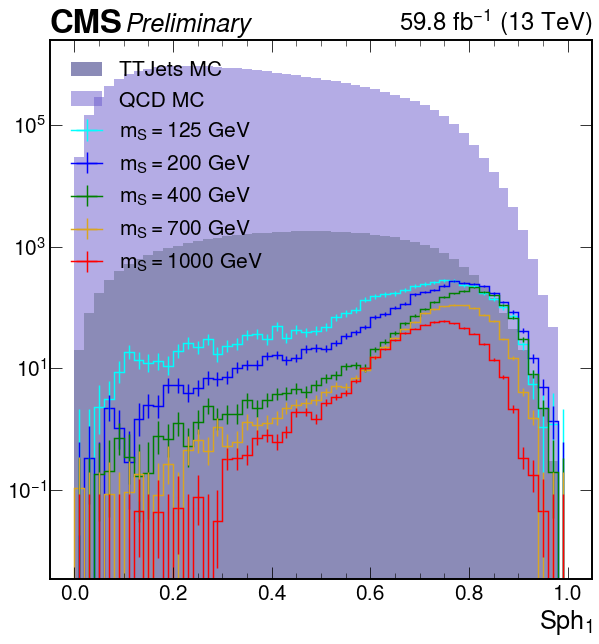

In [33]:
plot_label = 'SUEP_S1_Cluster70'
year = '2018'

temp = '3.0'
mPhi = '3.0'
decay = 'generic'
samples = ['TTJets_'+year, 'QCD_HT_'+year, 
            'mS125_T'+temp+'_mPhi'+mPhi+'_'+decay+'_'+year,
            'mS200_T'+temp+'_mPhi'+mPhi+'_'+decay+'_'+year,
            'mS400_T'+temp+'_mPhi'+mPhi+'_'+decay+'_'+year,
            'mS700_T'+temp+'_mPhi'+mPhi+'_'+decay+'_'+year,
            'mS1000_T'+temp+'_mPhi'+mPhi+'_'+decay+'_'+year]
labels = ['TTJets MC', 'QCD MC',
          r'$m_{S}=125$ GeV',r'$m_{S}=200$ GeV',r'$m_{S}=400$ GeV',r'$m_{S}=700$ GeV',r'$m_{S}=1000$ GeV']
density = False

hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year))
hBkg, hSignal, cSignal = [], [], []
lBkg, lSignal, cBkg = [], [], []
for label, sample in zip(labels, samples):
    if sample not in plots.keys(): 
        print("Missing", sample)
        continue
    h = plots[sample][plot_label][::2j]
    if density:
        h = h/h.sum().value
    if 'mS' in sample: 
        hSignal.append(h)
        lSignal.append(label)
        cSignal.append(getColor(sample))
    else: 
        hBkg.append(h)
        lBkg.append(label)
        cBkg.append(getColor(sample))
    
hep.histplot(hBkg, yerr=True, label=lBkg, color=cBkg, histtype='fill', alpha=0.5, stack=True) 
if len(hSignal)>0: hep.histplot(hSignal, yerr=True, label=lSignal, color=cSignal, stack=False) 

# tweak these by hand, as needed
#plt.ylim(1e-1,1e8)
#plt.xlim(1200,10000)
plt.legend(loc='best')
plt.yscale("log")

# save and show
if saveToAN: plt.savefig(AN_label.format("sph_"+year))
plt.savefig(output_label+plot_label+"_"+year+file_ext)
plt.show()

In [17]:
plot_label = 'SUEP_S1_Cluster70'

temp = '3.0'
mPhi = '3.0'
decay = 'generic'
samples = ['mS125_T'+temp+'_mPhi'+mPhi+'_'+decay,
            'mS400_T'+temp+'_mPhi'+mPhi+'_'+decay,
            'mS700_T'+temp+'_mPhi'+mPhi+'_'+decay,
            'mS1000_T'+temp+'_mPhi'+mPhi+'_'+decay]

for sample in samples:
    line = ''
    
    mS = sample[sample.find('_mS')+3:sample.find('_T')]
    label = '$T = '+str(temp)+' \GeV$, $m_{\phi}= '+str(mPhi)+'\GeV$, $m_S = ' + str(mS) + ' \GeV$'
    line += label
    line += ' & '
    
    for i, year in enumerate(['2016', '2017', '2018']):
        tot = plots[sample+'_'+year][plot_label].sum().value
        passing = plots[sample+'_'+year][plot_label][0.5j:].sum().value
        line += str(round(passing/tot, 2))
        if i != 2:
            line += ' & '
        else:
            line += ' \\\\ '
    print(line)

$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 125 \GeV$ & 0.83 & 0.84 & 0.86 \\ 
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 400 \GeV$ & 0.97 & 0.97 & 0.98 \\ 
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 700 \GeV$ & 0.97 & 0.98 & 0.98 \\ 
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 1000 \GeV$ & 0.98 & 0.99 & 0.98 \\ 


### SUEP ISR Comparison

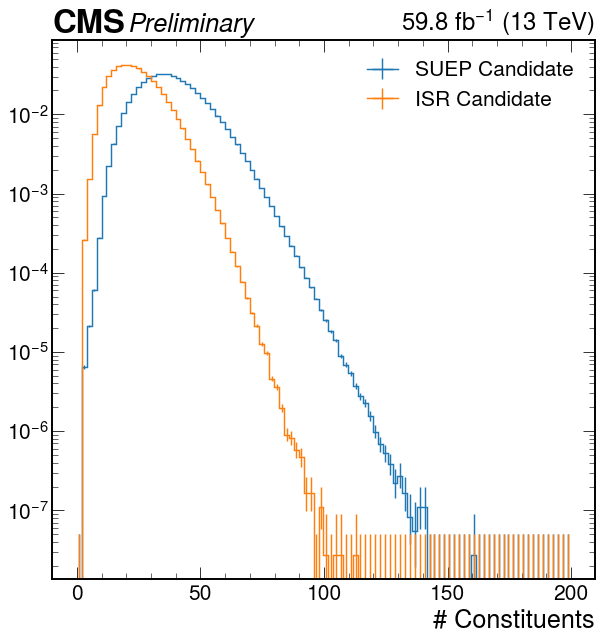

In [62]:
variable = 'nconst'
year = '2018'
sample = 'MC_{}'.format(year)
density = True

plot_labels = ['SUEP_{}_Cluster70'.format(variable), 
               'ISR_{}_ClusterInverted'.format(variable)]
objects = ['SUEP Candidate', 'ISR Candidate']

fig, ax = plt.subplots()
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))

for plot_label, obj in zip(plot_labels, objects): 
    h = plots[sample][plot_label][:200j:2j]
    hep.histplot(h, yerr=True, density=density, label=obj) 

fig.axes[0].set_yscale("log")
fig.axes[0].legend()

# save and show
if saveToAN: plt.savefig(AN_label.format("ISR_SUEP_"+variable))
plt.savefig(output_label+plot_label+"_"+year+file_ext)
plt.show()

## Ch. 5 Background Estimation with Extended ABCD

### 2D Background

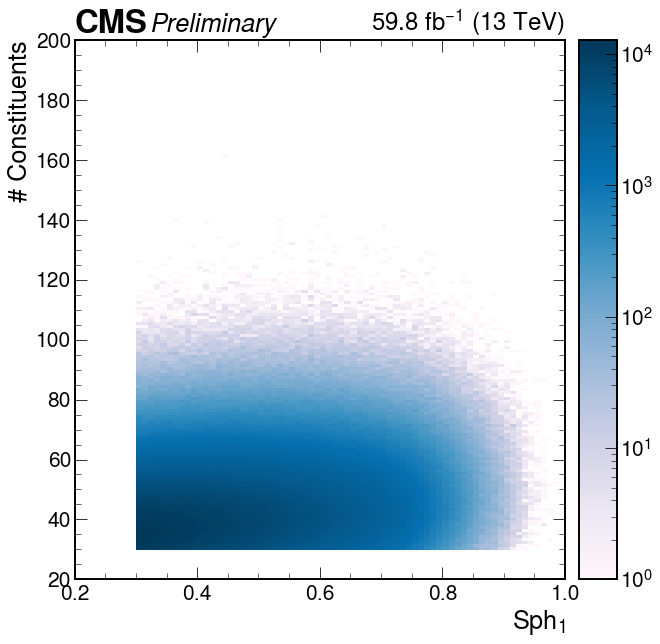

In [58]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
year = '2018'
sample = 'data_'+year
doLinearFit = False

fig, ax = plt.subplots(figsize=(10, 10))
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
h = h[0.3j:,30j:]

hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=True,
           label=sample) 

if doLinearFit:
    p = linearFit2DHist(h)
    plt.plot(h.axes[0].centers, p(h.axes[0].centers), label="Linear fit result:"+str(p), color='black', linestyle='dashed')
    plt.legend()

plt.ylim(20,200)
plt.xlim(0.2,1.0)

if saveToAN: plt.savefig(AN_label.format("2D_decorrelate_"+year))
plt.savefig(output_label+"2D_decorrelate_"+year+file_ext)
plt.show()

### Slices of ABCD Variables

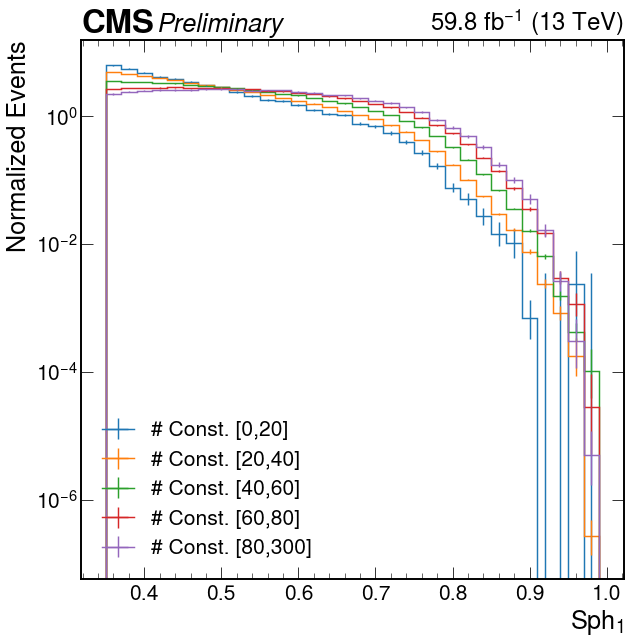

In [62]:
# parameters
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
year = '2018'
samples = ['QCD_HT_'+year, 'TTJets_'+year] # these are ADDED

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=round(lumiLabel(year),1))

slices = [[0j,20j],[20j,40j],[40j,60j],[60j,80j],[80j,300j]]
for j in range(len(slices)):
    val_lo = slices[j][0]
    val_up = slices[j][1]

    for i, sample in enumerate(samples):
        if i==0: h = plots[sample][plot_label][0.35j::2j,val_lo:val_up:sum]
        else: h += plots[sample][plot_label][0.35j::2j,val_lo:val_up:sum]
         
    hep.histplot(h,
                 yerr=True, density=True, 
                 label="# Const. [{0},{1}]".format(round(val_lo.imag), round(val_up.imag)))    

plt.legend()
#plt.ylim(1e-6,1e0)
plt.yscale('log')
plt.ylabel("Normalized Events")
plt.xlabel(r"$Sph_{1}$")

if saveToAN: plt.savefig(AN_label.format("1D_decorrelate_" + year))
plt.savefig(output_label + "1D_decorrelate_" + year + file_ext,  bbox_inches='tight')
plt.show()

### 2D Background with ABCD Regions

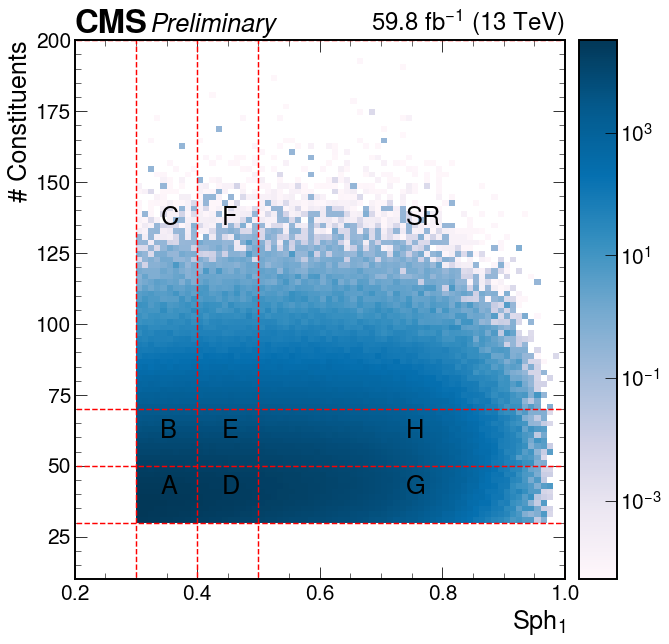

In [64]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
year = '2018'
samples = ['QCD_HT_'+year, 'TTJets_'+year] # NOTE: these are ADDED

draw_lines = True
lines_x = [0.3, 0.4, 0.5, 1.0]
lines_y = [30, 50, 70, 200]

fig, ax = plt.subplots(figsize=(10, 10))

k = 0
regions = ['A','B','C','D','E','F','G','H','SR']
for i in range(len(lines_x)-1):
    for j in range(len(lines_y)-1):
        xloc = (lines_x[i+1] + lines_x[i])/2 - 0.01
        yloc = (lines_y[j+1] + lines_y[j])/2
        plt.text(xloc, yloc, regions[k])
        k+=1
    
for i, sample in enumerate(samples):
    if i == 0: h = plots[sample][plot_label].copy()
    else: h += plots[sample][plot_label].copy()
    
bins = np.linspace(0,500,10)
h = h[0.3j:,30j::2j]

hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=True,
           label=sample) 

# draw lines to visualize ABCD regions
if draw_lines:
    for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
    for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')

plt.ylim(10,200)
plt.xlim(0.2,1.0)

if saveToAN: plt.savefig(AN_label.format("extendedABCD_regions_2018"))
plt.savefig(output_label+plot_label+"_"+year+file_ext)
plt.show()

### ABCD 1D Backgrounds

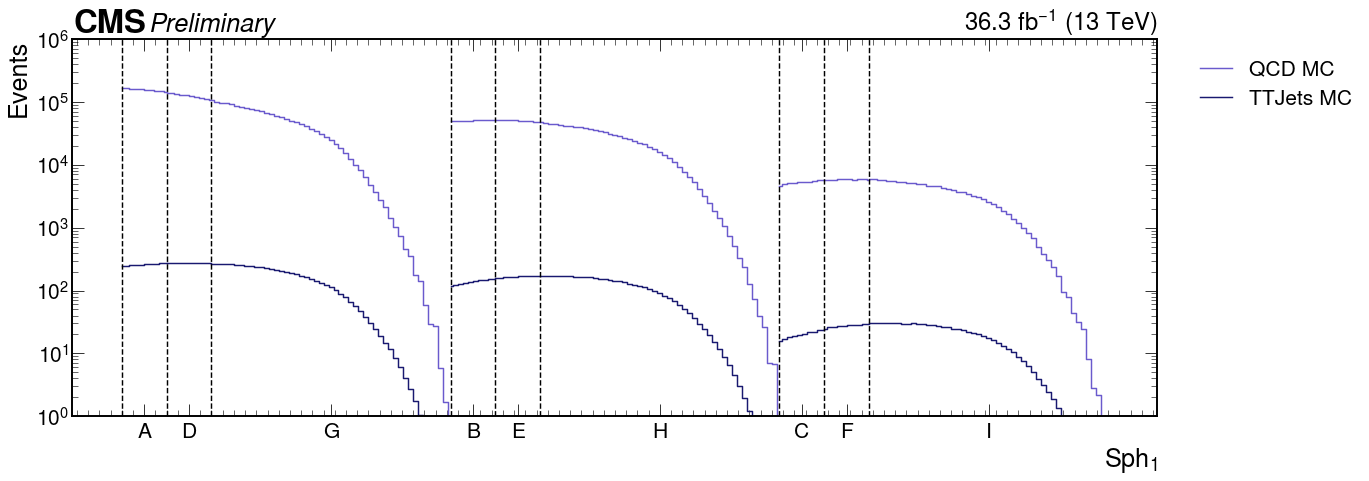

In [65]:
x = 'ABCDEFGHI'
y = 'ADGBEHCFI'
year = '2016'
plot_labels = ['SUEP_S1_Cluster70']
samples = ['QCD_HT_'+year, 'TTJets_'+year]
#samples = ['QCD_HT_'+year]
labels = ['QCD MC', 'TTJets MC']
#labels = ['QCD']

for plot_label in plot_labels:

    fig, ax = plot_all_regions(plots, 'A_'+plot_label, samples, 
                               labels=labels, regions=y, density=False)
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=ax)

    ax.set_ylim(1e0, 1e6)
    ax.set_xlabel(r"$Sph_1$")

    if saveToAN: fig.savefig(AN_label.format('backgrounds_'+year), bbox_inches='tight')
    fig.savefig(output_label + 'backgrounds_' + year + file_ext, bbox_inches='tight')

### F, C, SR Distributions

Text(0, 1, 'Error on $\\int^{UB}_{70} F ~/~ \\int^{UB}_{70} C$')

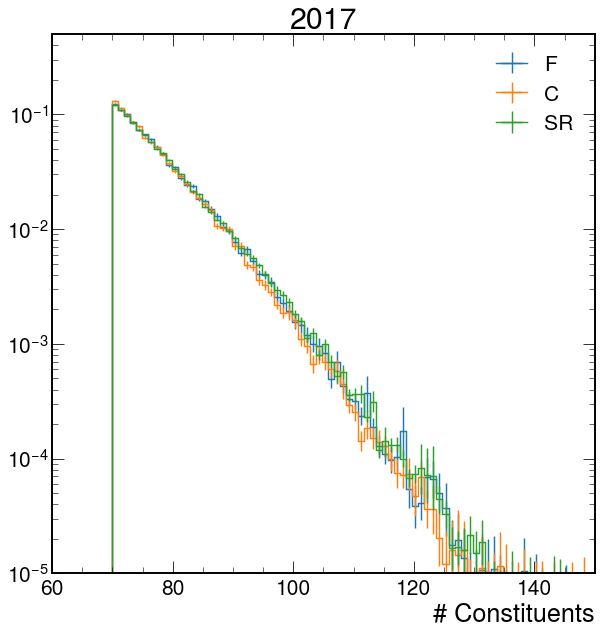

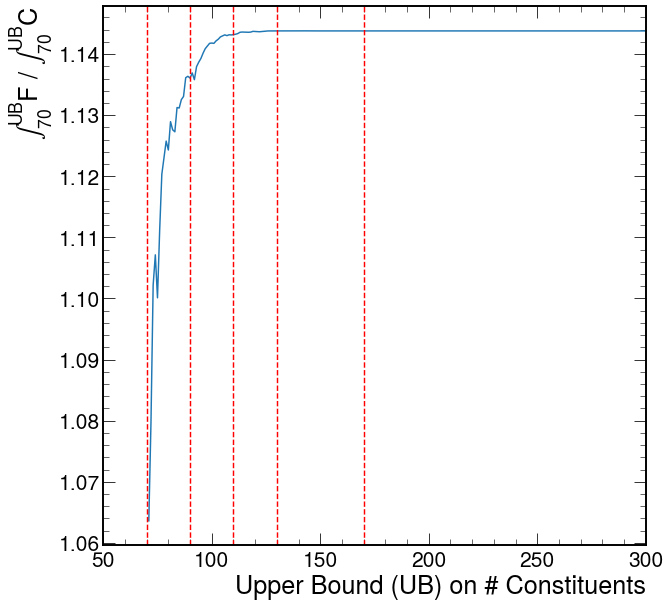

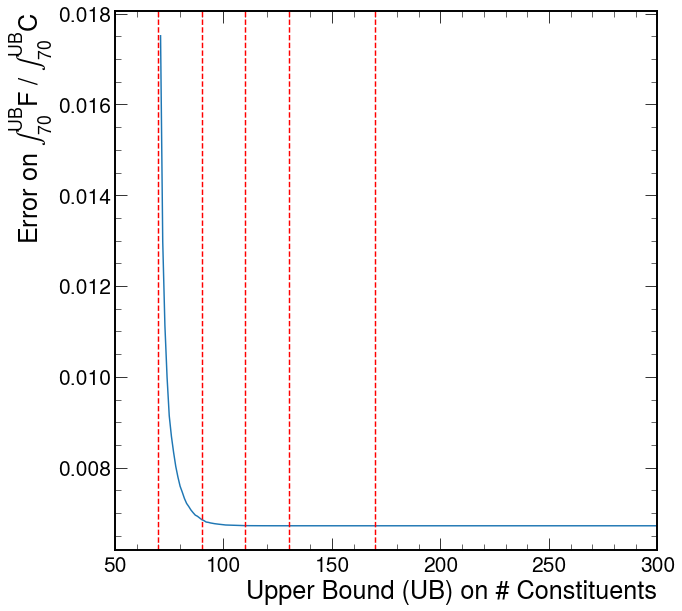

In [67]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
year = '2017'
sample = 'MC'
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 1000j]
new_bins = [70, 90, 100, 110, 170, 500]
rebin = False
density = True

abcd = plots["{}_{}".format(sample,year)][plot_label].copy()

C = abcd[xregions[0]:xregions[1]:sum, yregions[-2]:].copy()
F = abcd[xregions[1]:xregions[2]:sum, yregions[-2]:].copy()
SR = abcd[xregions[-2]::sum, yregions[-2]:].copy()

cuts = np.linspace(yregions[-2].imag+1, yregions[-1].imag, int((yregions[-1].imag-yregions[-2].imag)))
ratios = []
errs = []
for n in cuts:
    sumC = C[yregions[-2]:n*1.0j].sum().value
    sumF = F[yregions[-2]:n*1.0j].sum().value
    err = np.sqrt( sumF/sumC**2 + sumF**2 / sumC**3)
    ratios.append(sumF/sumC)
    errs.append(err)

if rebin:
    F = rebin_piecewise(F, new_bins)
    C = rebin_piecewise(C, new_bins)
    SR = rebin_piecewise(SR, new_bins)

    print("F", F.values())
    print("C", C.values())
    print("SR", SR.values())

if density:
    F /= F.sum().value
    C /= C.sum().value
    SR /= SR.sum().value

fig = plt.figure()
ax = fig.subplots()
ax.set_title(year)
hep.histplot(F, yerr=True, label='F', ax=ax) 
hep.histplot(C, yerr=True, label='C', ax=ax) 
hep.histplot(SR, yerr=True, label='SR', ax=ax)
ax.set_yscale("log")
ax.set_xlim(60, 150)
ax.set_ylim(1e-5, 5e-1)
ax.legend()
# if saveToAN: fig.savefig(AN_label.format("SRFC_"+sample+"_"+year))
# fig.savefig(output_label+"SRFC_"+sample+"_"+year+file_ext)

fig = plt.figure()
ax = fig.subplots()
ax.plot(cuts, ratios)
ax.axvline(70, color='red', linestyle='dashed')
ax.axvline(90, color='red', linestyle='dashed')
ax.axvline(110, color='red', linestyle='dashed')
ax.axvline(130, color='red', linestyle='dashed')
ax.axvline(170, color='red', linestyle='dashed')
ax.axvline(500, color='red', linestyle='dashed')
ax.set_xlim(50, 300)
ax.set_xlabel("Upper Bound (UB) on # Constituents")
ax.set_ylabel(r"$\int^{UB}_{70} F ~/~ \int^{UB}_{70} C$")

fig = plt.figure()
ax = fig.subplots()
ax.plot(cuts, errs)
ax.axvline(70, color='red', linestyle='dashed')
ax.axvline(90, color='red', linestyle='dashed')
ax.axvline(110, color='red', linestyle='dashed')
ax.axvline(130, color='red', linestyle='dashed')
ax.axvline(170, color='red', linestyle='dashed')
ax.axvline(500, color='red', linestyle='dashed')
ax.set_xlim(50, 300)
ax.set_xlabel("Upper Bound (UB) on # Constituents")
ax.set_ylabel(r"Error on $\int^{UB}_{70} F ~/~ \int^{UB}_{70} C$")

### F/C Values

2016
Ratio F/C: [0.99246464 1.13623287 1.39025748 7.16754965        nan]
Error on F/C [0.00772661 0.03891163 0.2340943  7.60233444 0.        ]
Ratio SR/F: [0.99499443 1.09328804 0.97204029 0.52073587        nan]
Error on Ratio SR/F [0.00645857 0.0296597  0.12448993 0.25303215 0.        ]
Predicted F/C [0.9924646382529885, 1.136232870885661, 1.2800011035183336, 1.4956534524673424, 2]
Midpoints [80.0, 100.0, 120.0, 150.0, 335.0]

2017
Ratio F/C: [0.98902249 1.20856516 1.78340648 0.65246579        nan]
Error on F/C [0.00692193 0.03734696 0.28083272 0.49832898 0.        ]
Ratio SR/F: [0.99332831 1.11126219 1.07890307 1.98981084        nan]
Error on Ratio SR/F [0.00575094 0.0264105  0.11615277 1.27449895 0.        ]
Predicted F/C [0.989022486796582, 1.2085651649673748, 1.4281078431381675, 1.7574218603943565, 2]
Midpoints [80.0, 100.0, 120.0, 150.0, 335.0]

2018
Ratio F/C: [0.99177259 1.15448476 1.50453764 2.20827299        nan]
Error on F/C [0.00599484 0.0310322  0.19869369 1.84757374 0.   

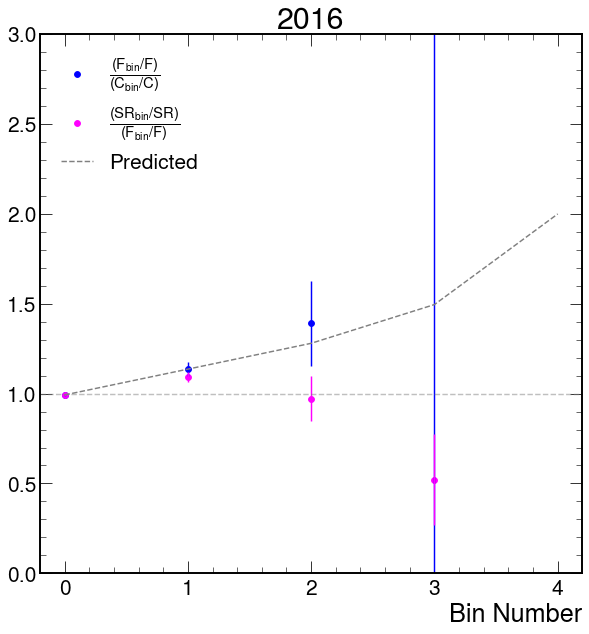

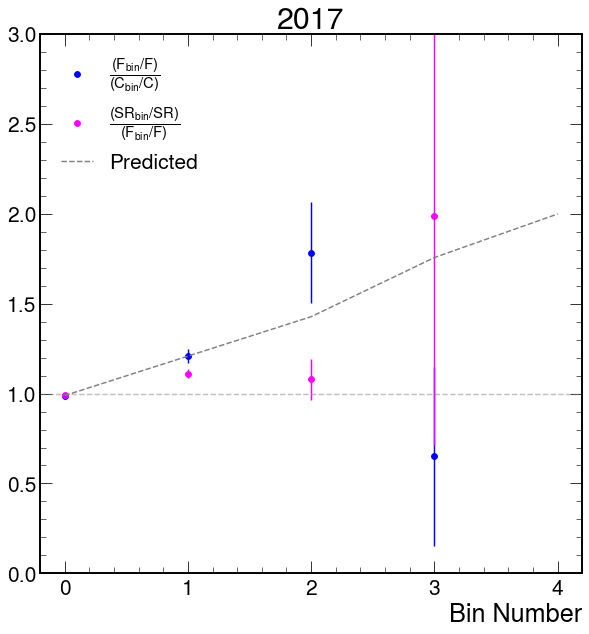

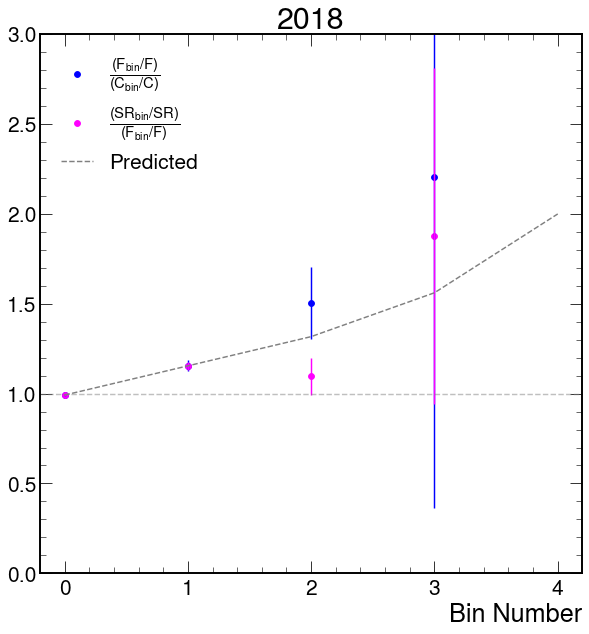

In [17]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
sample = 'data'
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 1000j]
new_bins = [70, 90, 110, 130, 170, 500]
rebin = True    # RUN BOTH!

systABCD = {}
for year in ['2016', '2017', '2018']:
    abcd = plots["{}_{}".format(sample,year)][plot_label].copy()
    C = abcd[xregions[0]:xregions[1]:sum, yregions[-2]:].copy()
    F = abcd[xregions[1]:xregions[2]:sum, yregions[-2]:].copy()
    SR = abcd[xregions[-2]::sum, yregions[-2]:].copy()

    if rebin:
        F_binned = rebin_piecewise(F, new_bins)/F.sum().value
        C_binned = rebin_piecewise(C, new_bins)/C.sum().value
        SR_binned = rebin_piecewise(SR, new_bins)/SR.sum().value
    else:
        F_binned = F.copy()[::4j]/F.sum().value
        C_binned = C.copy()[::4j]/C.sum().value
        SR_binned = SR.copy()[::4j]/SR.sum().value

    ratio_FC = (F_binned.values())/(C_binned.values()) 
    ratio_SRF = (SR_binned.values())/(F_binned.values()) 
    ratio_FC_err = np.where(
        C_binned.values() > 0,
        np.sqrt((C_binned.values()**-2)*(F_binned.variances()) + (F_binned.values()**2 * C_binned.values()**-4)*(C_binned.variances())),
        0
    )
    ratio_SRF_err = np.where(
        F_binned.values() > 0,
        np.sqrt((F_binned.values()**-2)*(SR_binned.variances()) + (SR_binned.values()**2 * F_binned.values()**-4)*(F_binned.variances())),
        0
    )

    systABCD[year] = {}
    #systABCD[year]['values'] = ratio_FC
    #systABCD[year]['errors'] = ratio_FC_err

    if rebin:
        midpoints = [(new_bins[i] + new_bins[i+1]) / 2 for i in range(len(new_bins) - 1)]
        slope = (ratio_FC[1] - ratio_FC[0]) / (midpoints[1] - midpoints[0])
        intercept = ratio_FC[0] - slope * midpoints[0]
        predicted_FC = np.concatenate((ratio_FC[:2],[slope * xi + intercept for xi in midpoints[2:]]))
        predicted_FC = [x if x < 2 else 2 for x in predicted_FC]
        
        systABCD[year]['values'] = predicted_FC

        print(year)
        print("Ratio F/C:", ratio_FC)
        print("Error on F/C", ratio_FC_err)
        print("Ratio SR/F:", ratio_SRF)
        print("Error on Ratio SR/F", ratio_SRF_err)
        print("Predicted F/C", predicted_FC)
        print("Midpoints", midpoints)
        print()
        
    if rebin:
        xvalues = np.arange(0, len(ratio_SRF))
    else:
        xvalues = F_binned.axes[0].centers

    fig = plt.figure()
    ax = fig.subplots()
    ax.set_title(year)
    ax.scatter(xvalues, ratio_FC, color='blue', label=r'$\frac{(F_{bin}/F)}{(C_{bin}/C)}$')
    ax.errorbar(xvalues, ratio_FC, yerr=ratio_FC_err, color='blue', linestyle='')
    ax.scatter(xvalues, ratio_SRF, color='magenta', label=r'$\frac{(SR_{bin}/SR)}{(F_{bin}/F)}$')
    ax.errorbar(xvalues, ratio_SRF, yerr=ratio_SRF_err, color='magenta', linestyle='')
    ax.axhline(1, linestyle='dashed', color='gray', alpha=0.5)
    
    if rebin: 
        ax.plot(xvalues, predicted_FC, color='gray', linestyle='dashed', label='Predicted')
        ax.set_ylim(0,3)
        ax.set_xticks([0,1,2,3,4])
        ax.set_xlabel("Bin Number")
    else:
        ax.set_ylim(0.8, 2)
        ax.set_xlim(70, 150)
        ax.set_xlabel("# Constituents")

    ax.legend(loc='upper left')
    
    if rebin:
        if saveToAN: fig.savefig(AN_label.format("FC_"+sample+"_"+year))
        fig.savefig(output_label+"FC_"+sample+"_"+year+file_ext)
    else:
        if saveToAN: fig.savefig(AN_label.format("FC_unbinned_"+sample+"_"+year))
        fig.savefig(output_label+"FC_unbinned_"+sample+"_"+year+file_ext)

### Contamination in Regions

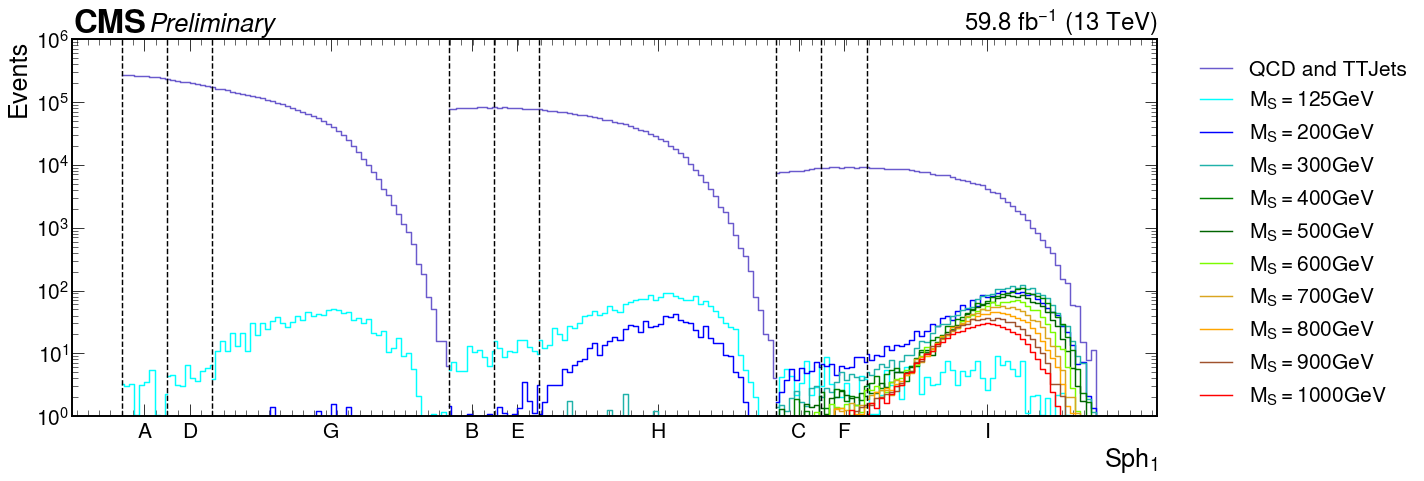

In [10]:
# mu = 1448.16781/34.8
# plots['scaled_M125_2018'] = fill_utils.apply_normalization(plots['M125_2018'], mu)

x = 'ABCDEFGHI'
y = 'ADGBEHCFI'
year = '2018'
plot_labels = ['SUEP_S1_Cluster70']
samples = ['MC_'+year] + ['mS{}_T3.0_mPhi3.0_generic_{}'.format(m, year) for m in [125,200,300,400,500,600,700,800,900,1000]]
labels = ['QCD and TTJets', r'$M_{S} = 125 GeV$', r'$M_{S} = 200 GeV$', r'$M_{S} = 300 GeV$',
          r'$M_{S} = 400 GeV$', r'$M_{S} = 500 GeV$', r'$M_{S} = 600 GeV$', r'$M_{S} = 700 GeV$',
          r'$M_{S} = 800 GeV$', r'$M_{S} = 900 GeV$', r'$M_{S} = 1000 GeV$']

for plot_label in plot_labels:

    fig, ax = plot_all_regions(plots, 'A_'+plot_label, samples, 
                               labels=labels, regions=y, density=False)
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=ax)

    ax.set_ylim(1e0, 1e6)
    ax.set_xlabel(r"$Sph_1$")

    if saveToAN: fig.savefig(AN_label.format('contamination_'+year), bbox_inches='tight')
    fig.savefig(output_label + 'contamination_' + year + file_ext, bbox_inches='tight')

### Contamination Table

In [79]:
plot_label = 'SUEP_S1_Cluster70'

masses = [125,400,700,1000]
T = [0.75, 12.0, 3.0, 1.5]
regions = 'ABCDEFGH'

for year in ['2018']:
    QCD_sample = 'QCD_HT_'+year
    lines = []
    ratios, indices = {}, {}
    for r in regions: 
        ratios.update({r:[]})
        indices.update({r:[]})
        
    for iSample, sample in enumerate([x for x in plots.keys() if 'mS' in x]):
        t = sample[sample.find('_T')+2:sample.find('_mPhi')]
        mPhi = sample[sample.find('_mPhi')+5:sample.find('_generic')]
        mS = sample[sample.find('_mS')+3:sample.find('_T')]
        
        label = '$T = '+str(t)+' \GeV$, $m_{\phi}= '+str(mPhi)+'\GeV$, $m_S = ' + str(mS) + ' \GeV$'
        
        line = label + ' & '
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label]
            hQCD = plots[QCD_sample][region + "_" + plot_label]
            alpha = h.sum().value
            beta = hQCD.sum().value
            total = alpha/beta * 100
            err = np.sqrt(alpha * (beta**-2) + (alpha**2) * (beta**-3)) * 100
            line += '$' + str(round(total,2)) + '\\pm' + str(round(err,2)) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
            
            
            ratios[region].append(total)
            indices[region].append(iSample)
            
        lines.append(line)    
        #print(line)
    
    for i, region in enumerate(regions):
        print(lines[indices[region][np.argmax(ratios[region])]])
    
    print()

$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 125 \GeV$ & $0.0\pm0.0$ & $0.01\pm0.0$ & $0.05\pm0.01$ & $0.0\pm0.0$ & $0.02\pm0.0$ & $0.04\pm0.01$ & $0.04\pm0.0$ & $0.14\pm0.0$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 125 \GeV$ & $0.0\pm0.0$ & $0.01\pm0.0$ & $0.05\pm0.01$ & $0.0\pm0.0$ & $0.02\pm0.0$ & $0.04\pm0.01$ & $0.04\pm0.0$ & $0.14\pm0.0$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 200 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.06\pm0.01$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.07\pm0.01$ & $0.0\pm0.0$ & $0.05\pm0.0$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 125 \GeV$ & $0.0\pm0.0$ & $0.01\pm0.0$ & $0.03\pm0.01$ & $0.0\pm0.0$ & $0.01\pm0.0$ & $0.02\pm0.0$ & $0.02\pm0.0$ & $0.08\pm0.0$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 125 \GeV$ & $0.0\pm0.0$ & $0.01\pm0.0$ & $0.05\pm0.01$ & $0.0\pm0.0$ & $0.02\pm0.0$ & $0.04\pm0.01$ & $0.04\pm0.0$ & $0.14\pm0.0$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 200 \GeV$ & $0.0\pm0.0$ & $0.0\pm0.0$ & $0.06\pm0.01$ & $0.0\pm0.0$ & $0.0\

### MC Closure

Chi^2: 3.804429549506902
Chi^2: 2.814596569712363
Chi^2: 5.8342947400071665


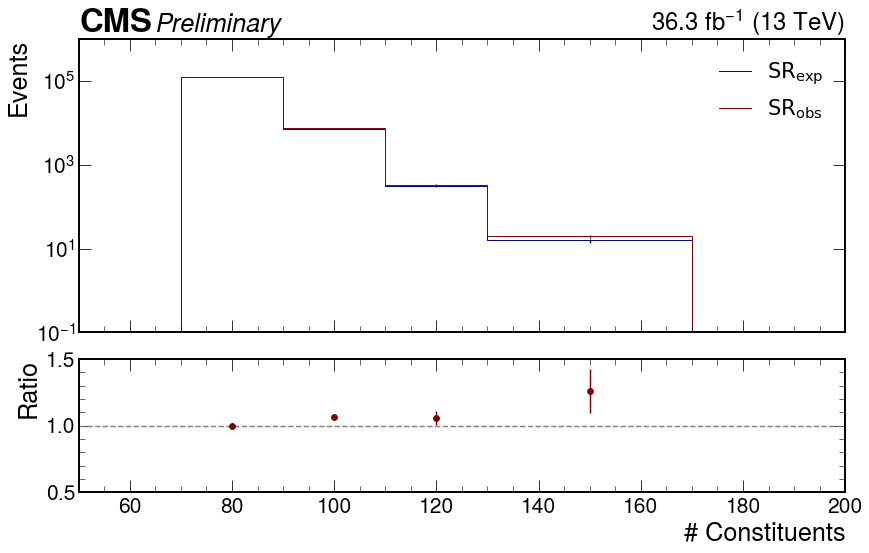

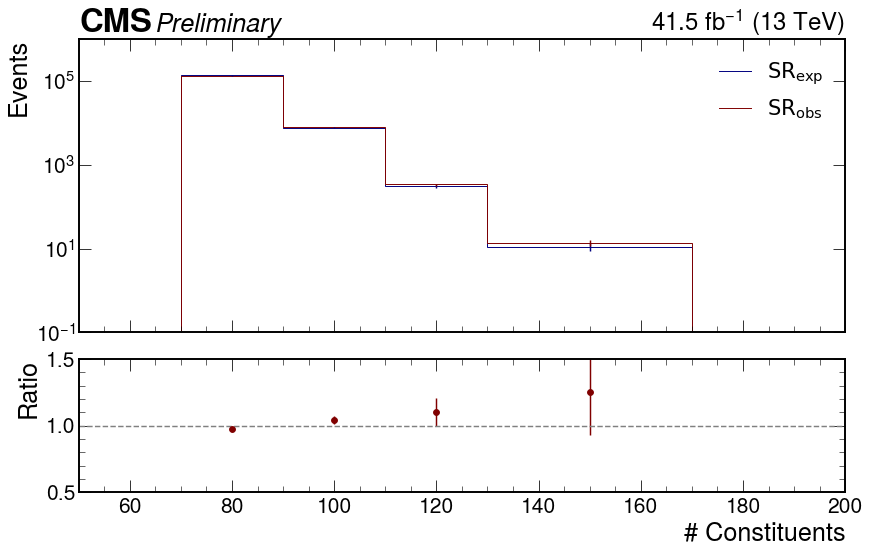

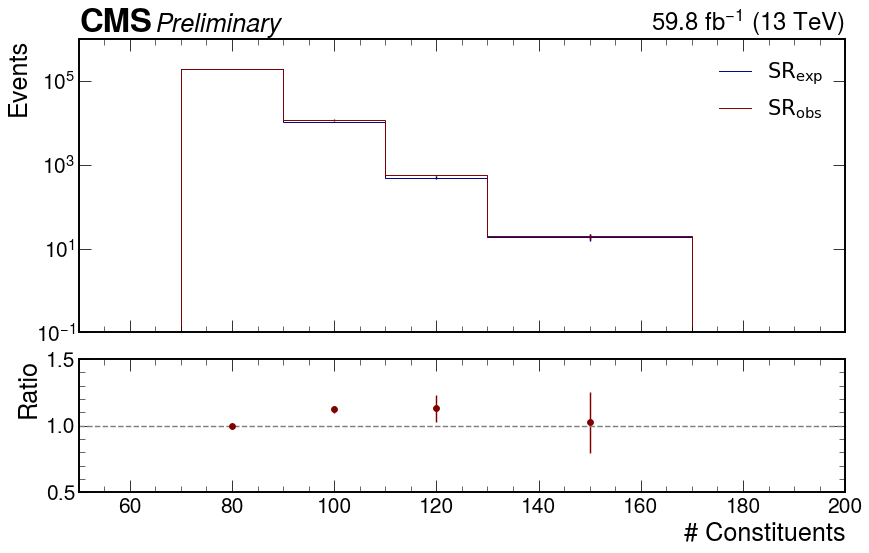

In [86]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
sample = 'MC'
rebin = True   # RUN BOTH!!
new_bins = [70, 90, 110, 130, 170, 500]
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 300j]

for year in ['2016', '2017', '2018']:
    abcd = plots["{}_{}".format(sample,year)][plot_label].copy()
    SR, SR_exp = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')

    if rebin:
        edges = SR.axes[0].edges
        SR = rebin_piecewise(SR, new_bins)
        SR_exp = rebin_piecewise(SR_exp, new_bins)

    # pull test
    diffs = np.abs(SR_exp.values() - SR.values())
    tot_sigma = np.sqrt(SR.variances() + SR_exp.variances())
    pull_ratios = np.where(tot_sigma > 0, diffs/tot_sigma, 0) + 1

    # chi2 test
    tot_sigma = np.sqrt(SR.variances() + SR_exp.variances())
    chi2 = np.sum(np.where(tot_sigma > 0, (SR.values() - SR_exp.values())**2 / tot_sigma**2, 0)) / len(tot_sigma[tot_sigma > 0])
    print("Chi^2:", chi2)

    # use the custom plot_ratio
    # the hist implementation used elsewhere in the notebook doesn't use the 
    # errors in the hists' bins to calculate the errors in the ratio plot
    #fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{exp}$", "$SR_{obs}$"], systs=np.array(systs[year]))
    fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{exp}$", "$SR_{obs}$"])

    #_ = axs[0].scatter([], [], marker='+', label='Pull')
    #_ = axs[1].scatter(SR.axes[0].centers, pull_ratios, marker='+', label='Pull')
    fig.set_size_inches(15, 12)
    #_ = axs[0].plot([],[],' ',label=r'$\chi^2$: {}'.format(round(chi2,1)))
    _ = axs[1].set_ylim(0.5, 1.5)
    #_ = axs[0].set_xlim(100, 150)
    _ = axs[0].legend(prop={"family":"DejaVu Sans"})
    #_ = axs[1].set_yticks(ticks=[0,1,2], labels=['-1','0','1'])
    #_ = axs[1].set_ylabel("1 - Ratio")
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])

    if rebin:
        _ = axs[0].set_ylim(1e-1, 1e6)
        _ = axs[0].set_xlim(50, 200)
        if saveToAN: plt.savefig(AN_label.format("closure_MC_"+year))
        plt.savefig(output_label+"closure_MC_"+year+file_ext)
    else:
        _ = axs[0].set_ylim(1e-1, 1e5)
        if saveToAN: plt.savefig(AN_label.format("unbinned_closure_MC_"+year))
        plt.savefig(output_label+"unbinned_closure_MC_"+year+file_ext)

### Control Regions Ratio

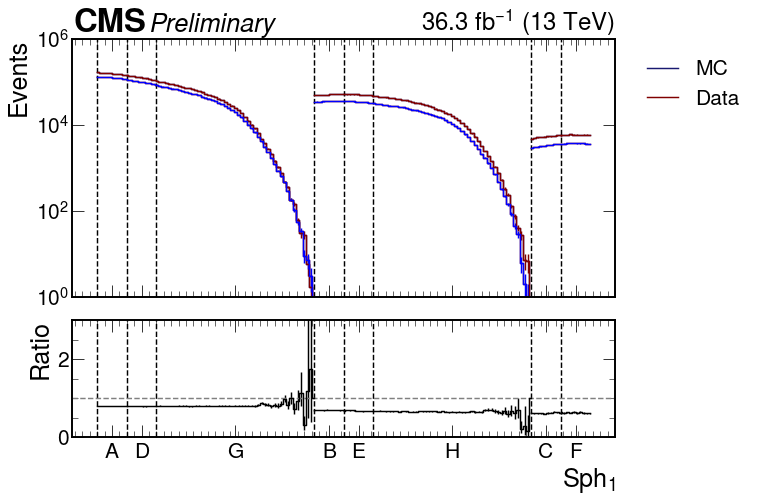

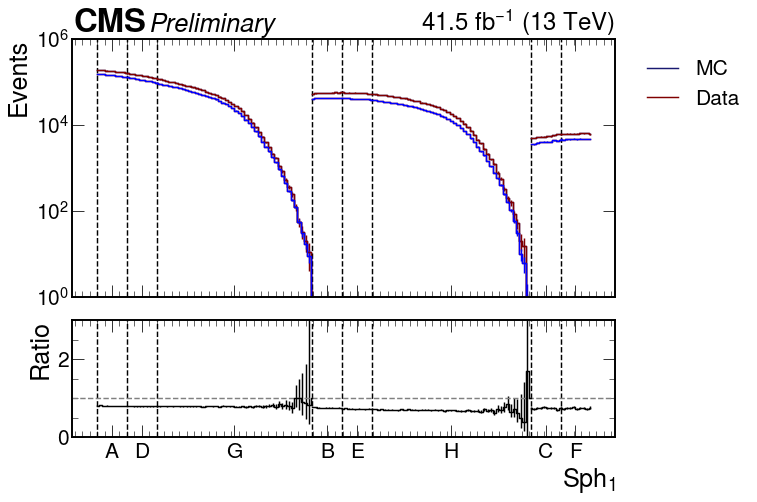

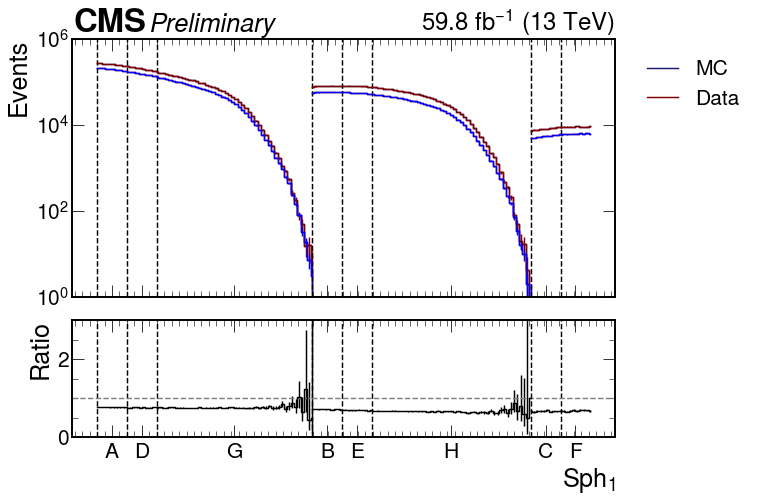

In [9]:
x = 'ABCDEFGH'
y = 'ADGBEHCF'
plot_label = 'SUEP_S1_Cluster70'

for year in ['2016', '2017', '2018']:
    fig, (ax1, ax2) = plot_ratio_regions(plots, 'A_'+plot_label, 
                           'MC_'+year, 'data_'+year, 
                           y, density=False)
    ax1.legend(labels=['MC', 'Data'], loc='upper left', bbox_to_anchor=(1.02, 1))
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=ax1)

    ax1.set_ylim(1e0, 1e6)
    ax2.set_ylim(0, 3)

    if saveToAN: plt.savefig(AN_label.format("control_regions_ratio_" + year), bbox_inches='tight')
    fig.savefig(output_label + 'control_regions_ratio_' + year + file_ext, bbox_inches='tight')

### Signal Region 

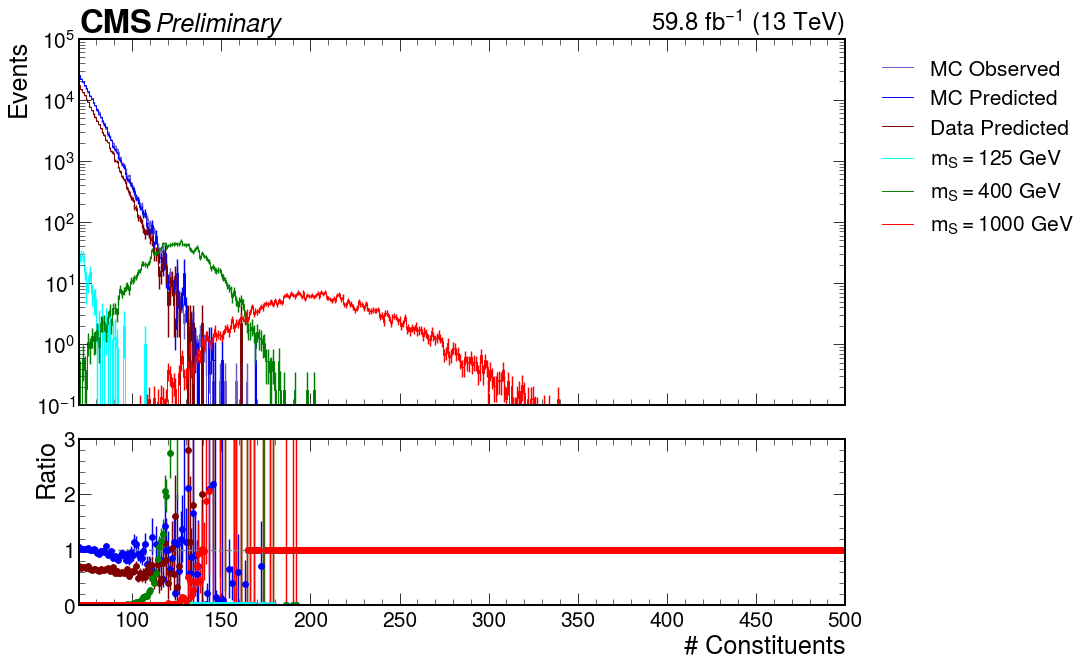

In [16]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
year = '2018'
abcdBkg = plots['QCD_HT_'+year][plot_label] + plots['TTJets_'+year][plot_label]
masses = [125, 400, 1000]
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 500j]

SR, SR_exp = ABCD_9regions_errorProp(abcdBkg, xregions, yregions, sum_var='x')
_, SR_exp_data = ABCD_9regions_errorProp(plots['data_'+year][plot_label], xregions, yregions, sum_var='x')

hlist = [SR, SR_exp, SR_exp_data]
colors = [getColor('QCD_HT'), 'blue', getColor('data')]
labels = ['MC Observed', 'MC Predicted', 'Data Predicted']
for mass in masses:
    sample = 'mS{}_T3.0_mPhi3.0_generic_{}'.format(mass, year)
    label = r'$m_{S}={'+str(mass)+'}$ GeV'
    if sample not in plots.keys(): continue
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[0.5j:1.0j:sum, 70j:500j]
    hlist.append(SUEP_SR)
    labels.append(label)
    colors.append(getColor(sample))

fig, axs = plot_ratio(hlist, labels=labels, cmap=colors)
fig.set_size_inches(15, 15, forward=True)
axs[0].set_xlim(70, 500)
axs[0].set_ylim(1e-1, 1e5)
hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])
axs[0].legend(bbox_to_anchor=(1.02,1))
axs[1].set_ylim(0, 3)

if saveToAN: plt.savefig(AN_label.format("final_"+year), bbox_inches='tight')
plt.savefig(output_label+"final_"+year+file_ext, bbox_inches='tight')

## Ch. 6 Systematics

### ABCD Systematic Table
*Note*: you need to run the cell "ABCD - F/C" before this.

In [18]:
labels = [
    r'& & & $\# Const. \in ( 70, 90]$ & & &\\',
    r'& & & $\# Const. \in ( 90, 110]$ & & &\\',
    r'& & & $\# Const. \in ( 110, 130]$ & & &\\',
    r'& & & $\# Const. \in ( 130, 170]$ & & &\\',
    r'& & & $\# Const. \in ( 170, \inf]$ & & &\\',      
]
yield_syst = ['1.08', '1.08', '1.08']

for i in range(len(systABCD['2018']['values'])):
    line = ''
    if i == 0: line += 'Shape Systematic & Uncorrelated & Correlated & '
    else: line += '& & & '
    line += 'Bin {} & '.format(i)
    for year in systABCD.keys():
        v = systABCD[year]['values'][i]
        if np.isnan(v): 
            v = 2
        v = min(v, 2.0)
        if i == 0: line += 'N/A'
        else: line += str(round(v, 3))
        if year != '2018': line += ' & '
    line += r'\\'
    print(line)
    print(labels[i])

print(r'\hline')

# for i in range(len(table['2018']['values'])):
#     line = ''
#     if i == 0: line += 'Shape Statistical & Uncorrelated  & Uncorrelated & '
#     else: line += '& & & '
#     line += 'Bin {} & '.format(i)
#     for year in table.keys():
#         v, e = table[year]['values'][i], table[year]['errors'][i]
#         if np.isnan(v): 
#             v = 1
#             e = 1
#         if i == 0: line += 'N/A'
#         else: line += str(round(1 + e/v, 3))
#         if year != '2018': line += ' & '
#     line += r'\\'
#     print(line)
#     print(labels[i])

# print(r'\hline')

print("Yield Uncertainty & Uncorrelated & Correlated & All bins & ", ' & '.join(yield_syst), r' \\ ')

Shape Systematic & Uncorrelated & Correlated & Bin 0 & N/A & N/A & N/A\\
& & & $\# Const. \in ( 70, 90]$ & & &\\
& & & Bin 1 & 1.136 & 1.209 & 1.154\\
& & & $\# Const. \in ( 90, 110]$ & & &\\
& & & Bin 2 & 1.28 & 1.428 & 1.317\\
& & & $\# Const. \in ( 110, 130]$ & & &\\
& & & Bin 3 & 1.496 & 1.757 & 1.561\\
& & & $\# Const. \in ( 130, 170]$ & & &\\
& & & Bin 4 & 2 & 2 & 2\\
& & & $\# Const. \in ( 170, \inf]$ & & &\\
\hline
Yield Uncertainty & Uncorrelated & Correlated & All bins &  1.08 & 1.08 & 1.08  \\ 


### SUEP Systematics Table

In [24]:
sys_list =  ['puweights', 'track','JER','JES','trigSF','PSWeight_ISR','PSWeight_FSR','prefire','higgs_weights']
mass_list = [125, 400, 1000]
decay = 'generic'
mPhi = '3.0'
T = '3.0'

nconst_bins = [70, 90, 130, 170, 1000]
sph_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.rcParams.update({'font.size': 13})

upratios, downratios = nested_dict(3, float), nested_dict(3, float)
for year in ['2016', '2017', '2018']:
    for mass in mass_list:

        plot = plots['mS{}_T{}_mPhi{}_{}_{}'.format(mass, T, mPhi, decay, year)]

        for sys in sys_list:

            sig_nconst = plot['SUEP_nconst_Cluster70']
            up_nconst = plot['SUEP_nconst_Cluster70_{}_up'.format(sys)]
            down_nconst = plot['SUEP_nconst_Cluster70_{}_down'.format(sys)]

            sig_sph = plot['SUEP_S1_Cluster70']
            up_sph = plot['SUEP_S1_Cluster70_{}_up'.format(sys)]
            down_sph = plot['SUEP_S1_Cluster70_{}_down'.format(sys)]

            upratio = (up_nconst.sum().value/sig_nconst.sum().value - 1)*100
            upratios[str(mass)][year][sys] = upratio
            #print("Down", down_nconst.sum().value,  np.sqrt(down_nconst.sum().variance))
            downratio = (down_nconst.sum().value/sig_nconst.sum().value - 1)*100
            downratios[str(mass)][year][sys] = downratio

In [29]:
mass = '1000'

sys_list =  ['puweights', 'track','JER','JES','trigSF','PSWeight_ISR','PSWeight_FSR','prefire','higgs_weights']
correlations = {
    'puweights': "Correlated",
    'track': "Uncorrelated",
    'JER': "Correlated",
    'JES': "Correlated", 
    'trigSF': "Uncorrelated",
    'PSWeight_ISR': "Uncorrelated",
    'PSWeight_FSR': "Uncorrelated",
    'prefire': "Correlated",
    'higgs_weights': "Correlated"
}
labels = {
    'puweights': "Pileup Reweighting",
    'track': "Track Reconstruction",
    'JER': "JER",
    'JES': "JEC", 
    'trigSF': "Trigger Scale Factors",
    'PSWeight_ISR': "Parton Shower Weights - ISR",
    'PSWeight_FSR': "Parton Shower Weights - FSR",
    'prefire': "Prefire Weights",
    'higgs_weights': "Higgs Reweighting"
}
title = r'Systematic & Correlation & \% Effect 2016 & \% Effect in 2017 & \% Effect in 2018\\'
table = [title, r'\hline']
for iRow in range(len(sys_list)):
    
    sys = sys_list[iRow]
    row = labels[sys] + ' & ' + correlations[sys] + ' & '
    years = [2016, 2017, 2018]
    for year in years:
        
        if str(year) in upratios[mass].keys():
            val = max(abs(upratios[mass][str(year)][sys]), abs(downratios[mass][str(year)][sys]))
            val = round(val,2)
        else:
            val = '-'
            
        if year == years[-1]:
            row += str(val) + r' \\'
        else:
            row += str(val) + ' & '
        
    table.append(row)

lumirow = r'Luminosity Uncertainty & Partially & 1.2 & 2.3 & 2.5\\'
table.append(lumirow)

# copy and paste output into latex!
for row in table: print(row)

Systematic & Correlation & \% Effect 2016 & \% Effect in 2017 & \% Effect in 2018\\
\hline
Pileup Reweighting & Correlated & 0.66 & 0.49 & 0.41 \\
Track Reconstruction & Uncorrelated & 0.9 & 1.48 & 0.52 \\
JER & Correlated & 0.66 & 0.43 & 0.31 \\
JEC & Correlated & 5.44 & 1.55 & 2.17 \\
Trigger Scale Factors & Uncorrelated & 0.87 & 0.96 & 1.0 \\
Parton Shower Weights - ISR & Uncorrelated & 8.18 & 8.21 & 8.41 \\
Parton Shower Weights - FSR & Uncorrelated & 0.53 & 0.21 & 2.08 \\
Prefire Weights & Correlated & 0.0 & 0.0 & 0.0 \\
Higgs Reweighting & Correlated & 0.0 & 0.0 & 0.0 \\
Luminosity Uncertainty & Partially & 1.2 & 2.3 & 2.5\\


### HT Ratio

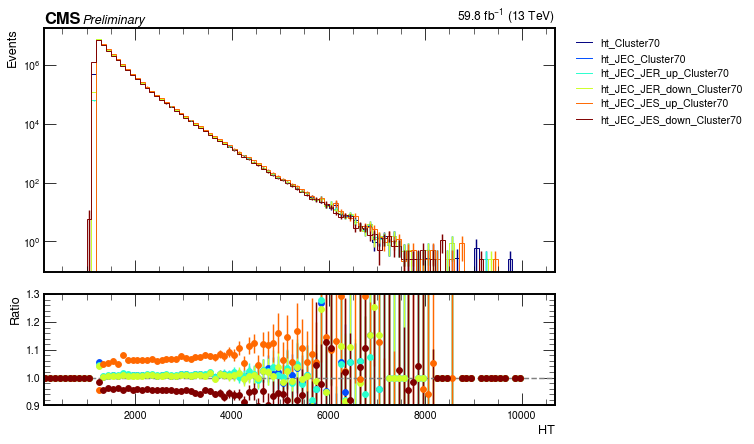

In [31]:
variables = ['ht_Cluster70', 'ht_JEC_Cluster70', 
             'ht_JEC_JER_up_Cluster70', 'ht_JEC_JER_down_Cluster70',
             'ht_JEC_JES_up_Cluster70', 'ht_JEC_JES_down_Cluster70']
year = '2018'
sample = 'QCD_HT_'+year
density = False

hlist = []
for var in variables:
    h = plots[sample][var]
    if density: h = h/h.sum().value
    hlist.append(h)

fig, axs = plot_ratio(hlist, labels=variables)
hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])
axs[0].legend(bbox_to_anchor=(1.02,1))
axs[1].set_ylim(0.9,1.3)

if saveToAN: fig.savefig(AN_label.format("HT_ratio_"+sample), bbox_inches='tight')
fig.savefig(output_label+"HT_ratio_"+sample+file_ext, bbox_inches='tight')
fig.show()

### Pearson Correlation of ABCD Variables

In [33]:
plot_labels = ['2D_ISR_S1_vs_ISR_nconst_ClusterInverted', '2D_SUEP_S1_vs_SUEP_nconst_Cluster70']
labels = ['ISR', 'SUEP']
samples = ['data_2016', 'data_2017', 'data_2018']

table = []
for plot_label in plot_labels:
    year = []
    for sample in samples:
        h = plots[sample][plot_label]
        h = h[0.3j:, 30j:]
        corr, error = hist2d_correlation(h)
        year.append([corr, error])
    table.append(year)

table = np.array(table)

for i in range(len(table)):
    values = table[i,:,0]
    errors = table[i,:,1]
    line = labels[i] + ' & '
    for v, e in zip(values, errors):
        v, e = sf(v, e)
        line += str(v) + ' $\pm$ ' + str(e) + ' & '
    line = line[:-2]
    line += r'\\'
    print(line)

ISR & 0.127 $\pm$ 0.0008 & 0.1315 $\pm$ 0.0008 & 0.1334 $\pm$ 0.0006 \\
SUEP & 0.1423 $\pm$ 0.0004 & 0.1547 $\pm$ 0.0004 & 0.156 $\pm$ 0.0004 \\


### Distance Correlation

In [ ]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform

def distance_correlation(x, y):
    
    n = x.shape[0]
    
    x = x.reshape((x.shape[0], 1))
    y = y.reshape((y.shape[0], 1))

    a = squareform(pdist(x, "euclidean"))
    b = squareform(pdist(y, "euclidean"))

    a_row_means = a.mean(axis=0, keepdims=True)
    b_row_means = b.mean(axis=0, keepdims=True)
    a_col_means = a.mean(axis=1, keepdims=True)
    b_col_means = b.mean(axis=1, keepdims=True)
    a_mean = a.mean()
    b_mean = b.mean()

    A = a - a_row_means - a_col_means + a_mean
    B = b - b_row_means - b_col_means + b_mean

    dcov = np.sqrt(np.multiply(A, B).mean())
    dvar_x = np.sqrt(np.multiply(A, A).mean())
    dvar_y = np.sqrt(np.multiply(B, B).mean())
    dcor = dcov / np.sqrt(dvar_x * dvar_y)
    
    return dcor

# Example usage
x = np.array([])
y = np.array([])
weights = np.array([])
lower_bounds = [30j, 40j, 50j, 60j, 70j]

samples = ['2D_ISR_S1_vs_ISR_nconst_ClusterInverted', '2D_SUEP_S1_vs_SUEP_nconst_Cluster70']
dcors = {}
for sample in samples:
    print(sample)
    dcors[sample] = [] # for each sample, store the average of each lower bound tried
    for lb in lower_bounds:
        print(lb)
        trials = []
        npoints = 10000
        for trial in range(100):
            abcd = plots['data_2018'][sample].copy()
            abcd = abcd[0.3j:1.0j, lb:150j].copy()
            xvals = abcd.axes[0].centers
            yvals = abcd.axes[1].centers
            zvals = abcd.to_numpy()[0]

            xindices = np.random.choice(len(xvals), size=npoints, replace=True)
            yindices = np.random.choice(len(yvals), size=npoints, replace=True)
            probs = np.random.rand(npoints)

            xvals = xvals[xindices]
            yvals = yvals[yindices]
            zvals = zvals[xindices, yindices]
            
            xvals = xvals[zvals > probs]
            yvals = yvals[zvals > probs]
            
            dcor = distance_correlation(xvals, yvals)
            trials.append(dcor)
        
        dcors[sample].append(np.mean(trials))
    
for sample in samples:
    plt.plot(np.array(lower_bounds).imag, dcors[sample], label=sample)
plt.legend()

Sample
30j
40j
50j
60j
70j
Sample
30j


### ISR Closure - Yield Systematic

In [36]:
plot_label = '2D_ISR_S1_vs_ISR_nconst_ClusterInverted'
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 500j]

table = []
labels = ['SR', 'Predicted SR', 'Ratio']
for year in ['2016', '2017', '2018']:
    
    sample = 'data_'+year
    abcd = plots[sample][plot_label].copy()

    SR, SR_exp, delta_SR_exp = ABCD_9regions_yield(abcd, xregions, yregions)

    ratio = SR/SR_exp
    delta_ratio = np.sqrt((SR_exp**-2)*(SR) + (SR**2 * SR_exp**-4)*(delta_SR_exp**2))
    table.append([SR, np.sqrt(SR), SR_exp, delta_SR_exp, ratio, delta_ratio])

table = np.array(table).T

for i in range(len(table)):
    if i%2: continue
    values = table[i]
    errors = table[i+1]
    line = labels[int(i/2)] + ' & '
    for v, e in zip(values, errors):
        v, e = sf(v, e)
        line += str(v) + ' $\pm$ ' + str(e) + ' & '
    line = line[:-2]
    line += r'\\'
    print(line)

SR & 835.0 $\pm$ 29.0 & 1080.0 $\pm$ 30.0 & 1370.0 $\pm$ 40.0 \\
Predicted SR & 830.0 $\pm$ 100.0 & 1130.0 $\pm$ 120.0 & 1160.0 $\pm$ 110.0 \\
Ratio & 1.01 $\pm$ 0.12 & 0.96 $\pm$ 0.11 & 1.18 $\pm$ 0.11 \\


## Ch. 7 Results

### Validation Region Contamination Table

In [40]:
# validation region
plot_label = 'SUEP_nconst_Cluster70'

regions = 'I'

ratios, lines = [], []
for year in ['2018']:
    QCD_sample = 'QCD_HT_'+year
    for sample in [x for x in plots.keys() if 'mS' in x]:
        t = sample[sample.find('_T')+2:sample.find('_mPhi')]
        mPhi = sample[sample.find('_mPhi')+5:sample.find('_generic')]
        mS = sample[sample.find('_mS')+3:sample.find('_T')]
        
        label = '$T = '+str(t)+' \GeV$, $m_{\phi}= '+str(mPhi)+'\GeV$, $m_S = ' + str(mS) + ' \GeV$'
        
        line = label + ' & '
        for i, region in enumerate(regions):
            h = plots[sample][region + "_" + plot_label][70j:90j]
            hQCD = plots[QCD_sample][region + "_" + plot_label][70j:90j]
            alpha = h.sum().value
            beta = hQCD.sum().value
            total = alpha/beta * 100
            
            ratios.append(total)
            
            err = np.sqrt(alpha * (beta**-2) + (alpha**2) * (beta**-3)) * 100
            line += '$' + str(round(total,2)) + '\\pm' + str(round(err,2)) + '$'

            if i == len(regions)-1: line += ' \\\\'
            else: line += ' & '
        # print(line)
        lines.append(line)
    print()
    
sorted_lines = np.array(lines)[np.argsort(ratios)]

for l in sorted_lines[-10:]:
    print(l)
    
print(np.mean(ratios))


$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 400 \GeV$ & $0.02\pm0.0$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 125 \GeV$ & $0.05\pm0.01$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 125 \GeV$ & $0.05\pm0.01$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 125 \GeV$ & $0.08\pm0.01$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 300 \GeV$ & $0.12\pm0.01$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 300 \GeV$ & $0.12\pm0.01$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 300 \GeV$ & $0.16\pm0.01$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 200 \GeV$ & $0.5\pm0.02$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 200 \GeV$ & $0.6\pm0.02$ \\
$T = 3.0 \GeV$, $m_{\phi}= 3.0\GeV$, $m_S = 200 \GeV$ & $0.87\pm0.02$ \\
0.08754364902104177


### Validation Region Yields

In [43]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 500j]

table = []
labels = ['SR', 'Predicted SR', 'Ratio']
for year in ['2016', '2017', '2018']:
    
    sample = 'data_'+year
    abcd = plots[sample][plot_label].copy()

    SR, SR_exp, delta_SR_exp = ABCD_9regions_yield(abcd, xregions, yregions)

    ratio = SR/SR_exp
    delta_ratio_stat = np.sqrt((SR_exp**-2)*(SR) + (SR**2 * SR_exp**-4)*(delta_SR_exp**2))
    delta_ratio_syst = 0.08
    table.append([SR, np.sqrt(SR), None, SR_exp, delta_SR_exp, None, ratio, delta_ratio_stat, delta_ratio_syst])

table = np.array(table).T

for i in range(len(table)):
    if i%3!=0: continue
    values = table[i]
    errors_stat = table[i+1]
    errors_syst = table[i+2]
    line = labels[int(i/3)] + ' & '
    for v, stat, syst in zip(values, errors_stat, errors_syst):
        if syst is not None:
            v = round(v, 2)
            stat = round(stat, 2)
            syst = round(syst, 2)
            line += str(v) + ' $\pm$ ' + str(stat) + ' (stat.) $\pm$ ' + str(syst) + ' (syst.) & '
        else:
            v, stat = sf(v, stat)
            line += str(v) + ' $\pm$ ' + str(stat) + ' & '
    line = line[:-2]
    line += r'\\'
    print(line)

SR & 79520.0 $\pm$ 280.0 & 100700.0 $\pm$ 300.0 & 137500.0 $\pm$ 400.0 \\
Predicted SR & 81200.0 $\pm$ 1200.0 & 105500.0 $\pm$ 1400.0 & 136200.0 $\pm$ 1500.0 \\
Ratio & 0.98 $\pm$ 0.01 (stat.) $\pm$ 0.08 (syst.) & 0.96 $\pm$ 0.01 (stat.) $\pm$ 0.08 (syst.) & 1.01 $\pm$ 0.01 (stat.) $\pm$ 0.08 (syst.) \\


### Table and Plots of Post-Fits, Limits
See SUEPLimits repo

The following is DEPRECATED

(1.0, 1000000.0)

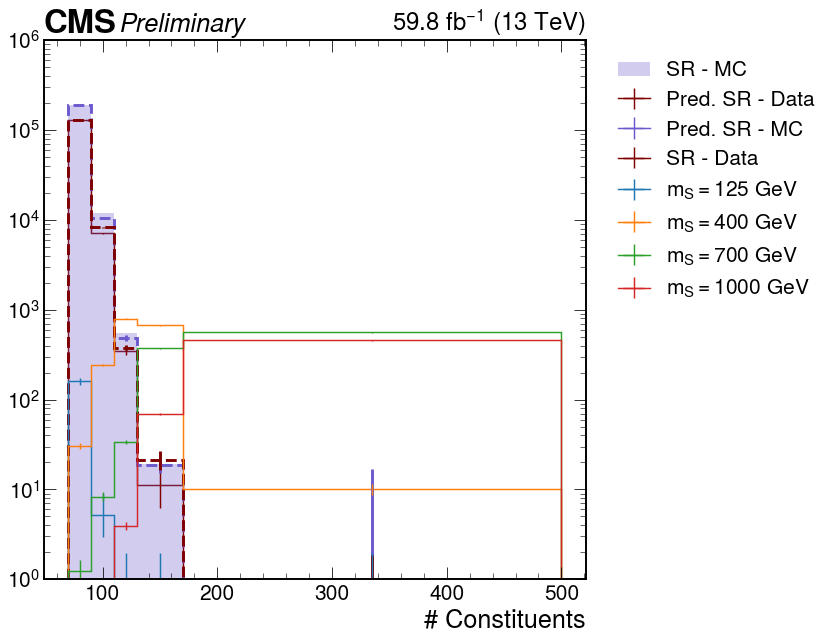

In [49]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
year = '2018'
abcd = plots['QCD_HT_'+year][plot_label]

newbins = [70, 90, 110, 130, 170, 500]
xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [30j, 50j, 70j, 500j]
SR, SR_exp = ABCD_9regions_errorProp(abcd, xregions, yregions, sum_var='x')
SR_data, SR_exp_data = ABCD_9regions_errorProp(plots['data_'+year][plot_label], xregions, yregions, sum_var='x')

fig, ax = plt.subplots()
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
hep.histplot(rebin_piecewise(SR_exp_data, newbins), yerr=True, label="Pred. SR - Data", color=default_colors['data'])    
hep.histplot(rebin_piecewise(SR, newbins), lw=3, histtype='fill', alpha=0.3,yerr=True, label="SR - MC", color=default_colors['QCD'])    
hep.histplot(rebin_piecewise(SR_exp, newbins), lw=3, yerr=True, label="Pred. SR - MC", color=default_colors['QCD'], linestyle='dashed')    
hep.histplot(rebin_piecewise(SR_data, newbins), lw=3, yerr=True, label="SR - Data", color=default_colors['data'], linestyle='dashed')    

# samples = ['SUEP-m125-generic-htcut_'+year, 'SUEP-m400-generic_'+year,
#           'SUEP-m750-generic_'+year, 'SUEP-m1000-generic_'+year]
# labels = [r'$M_{S}=125$ GeV',r'$M_{S}=400$ GeV',r'$M_{S}=750$ GeV',r'$M_{S}=1000$ GeV']
masses = [125, 400, 700, 1000]
for mass in masses:
    sample = 'mS{}_T3.0_mPhi3.0_generic_{}'.format(mass, year)
    label = r'$m_{S}='+str(mass)+'$ GeV'
    if sample not in plots.keys(): continue
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[xregions[-2]:1.0j:sum, yregions[-2]:500j]
    hep.histplot(rebin_piecewise(SUEP_SR, newbins), yerr=True, label=label)    

plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.yscale("log")
plt.ylim(1e0, 1e6)

## Appendix B

In [ ]:
plot_label = '2D_SUEP_S1_vs_SUEP_nconst_Cluster70'
year = '2018'
samples = [x for x in plots.keys() if 'mS' in x] + ['QCD_HT_'+year]
#samples =['QCD_HT_'+year]

draw_lines = True
lines_x = [0.3, 0.4, 0.5]
lines_y = [30, 50, 70]

fig, ax = plt.subplots(figsize=(10, 10))

decays = {
    'hadronic' : r"$A^' \rightarrow e^{+}e^{-},\mu^{+}\mu^{-},\pi^{+}\pi^{-}$""\n""with BR=15,15,70%",
    'leptonic' : r"$A^' \rightarrow e^{+}e^{-},\mu^{+}\mu^{-},\pi^{+}\pi^{-}$""\n""with BR=40,40,20%",
    'generic' : r"$A^' \rightarrow \pi^{+}\pi^{-}$""\n""with BR=100%"
}
    
for i, sample in enumerate(samples):
    h = plots[sample][plot_label]
    
    print(sample)
    
    bins = np.linspace(0,500,10)
    h = h[0.3j:,30j::2j]

    hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
    _ = hep.hist2dplot(h, 
               norm=matplotlib.colors.LogNorm(),
               cmap = 'PuBu',
               cbar=True,
               label=sample) 

    # draw lines to visualize ABCD regions
    if draw_lines:
        for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
        for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')

    plt.ylim(10,200)
    plt.xlim(0.2,1.0)
    
    if 'mS' in sample:
        plt.ylim(10,500)
        split = sample.split('_')
        (Mass,t,mdark,decay) = (float(split[0][2:]),float(split[1][1:]),float(split[2][4:]),split[3])

        plt.text(0.25, 366,r"$m_S$ = {}".format(Mass), fontsize='small')
        plt.text(0.25, 333,r"$m_\phi$ = {}".format(mdark), fontsize='small')
        plt.text(0.25, 300,"T = {}".format(t), fontsize='small')
        plt.text(0.25, 250,"decay = {}".format(decays[decay]), fontsize='small')

    if saveToAN: plt.savefig(AN_label.format("{}_{}_{}".format(plot_label, sample, year)))
    plt.savefig(output_label+plot_label+"_"+sample+"_"+year+file_ext)
    plt.show()

## Appendix E

### ML 2D Distributions of ABCD Variables

In [ ]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
sample = 'QCD_HT_2018'
#samples += ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
draw_lines = True
lines_x = [0.3,0.4, 0.5, 1.0]
lines_y = [0,0.5,1]

fig, ax = plt.subplots(figsize=(10, 10))

k = 0
regions = ['A','B','C','D','E','SR']
for i in range(len(lines_y)-1):
    for j in range(len(lines_x)-1):
        xloc = (lines_x[j+1] + lines_x[j])/2 - 0.01
        yloc = (lines_y[i+1] + lines_y[i])/2
        plt.text(xloc, yloc, regions[k])
        k+=1
    
if plots[sample][plot_label].sum().value == 0:
    print("Histogram empty for sample", sample)

h = plots[sample][plot_label]
h = h[0.3j:,:]

hep.cms.label(llabel='Preliminary',data=False, lumi=61.0)
_ = hep.hist2dplot(h, 
           norm=matplotlib.colors.LogNorm(),
           cmap = 'PuBu',
           cbar=True,
           label=sample) 

# draw lines to visualize ABCD regions
if draw_lines:
    for y in lines_y: plt.plot([0,10000], [y,y], color='red', linestyle='dashed')
    for x in lines_x: plt.plot([x,x], [0,1000], color='red', linestyle='dashed')

plt.ylim(0,1)
plt.xlim(0.2,1.0)

if saveToAN: plt.savefig(AN_label.format("ML_extendedABCD_regions_2018"))
plt.savefig(output_label+""+file_ext)
plt.show()

### ML Closure

In [ ]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
year = '2018'
abcd = plots['QCD_HT_'+year][plot_label]

xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [0.0j, 0.5j, 1.0j]

SR, SR_exp = ABCD_6regions(abcd, xregions, yregions, sum_var='x')

SR = SR[::2j]
SR_exp = SR_exp[::2j]

fig, axs = plot_ratio([SR_exp, SR], labels=["$SR_{obs}$", "$SR_{exp}$"])
_ = axs[1].set_ylim(0,2)
_ = axs[0].legend()
hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=axs[0])


if saveToAN: plt.savefig(AN_label.format("ML_closure_"+year))
plt.savefig(output_label+"ML_closure_"+year+file_ext)

### ML MC/Data

In [ ]:
x = 'ABCDE'
y = 'ABCDE'
year = '2018'
plot_labels = ['single_l5_bPfcand_S1_SUEPtracks_GNN']
for plot_label in plot_labels:
    fig, (ax1, ax2) = plot_ratio_regions(plots, 'A_'+plot_label, 
                           'data_'+year, 'QCD_HT_'+year,
                           y, density=False)
    ax1.legend(labels=['QCD','Data'], loc='upper left', bbox_to_anchor=(1.02, 1))
    hep.cms.label(llabel='Preliminary', data=False, lumi=lumiLabel(year), ax=ax1)

    ax1.set_ylim(1e0, 2e5)
    fig.set_size_inches(15, 6)
    
    if saveToAN: fig.savefig(AN_label.format("ML_control_regions_ratio_" + year))
    fig.savefig(output_label + 'ML_control_regions_ratio_' + year + file_ext, bbox_inches='tight')

### ML Signal Region

In [ ]:
plot_label = '2D_SUEP_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNN'
year = '2018'
abcd = plots['QCD_HT_'+year][plot_label]

xregions = [0.3j, 0.4j, 0.5j, 1.0j]
yregions = [0.0j, 0.5j, 1.0j]

SR, SR_exp = ABCD_6regions(abcd, xregions, yregions, sum_var='x')
_, SR_exp_data = ABCD_6regions(plots['data_'+year][plot_label], xregions, yregions, sum_var='x')

# use the custom plot_ratio
# the hist implementation used elsewhere in the notebook doesn't use the 
# errors in the hists' bins to calculate the errors in the ratio plot
# fig, axs, _ = plot_ratio(SR_exp, SR, 
#                          "# Constituents in SUEP", "$SR_{obs}$ - QCD", "$SR_{exp}$ - Data")
# _ = axs[1].set_ylim(0,3.0)
# _ = axs[0].legend()

fig, ax = plt.subplots(figsize=(10, 10))
hep.cms.label(llabel='Preliminary',data=False, lumi=lumiLabel(year))
hep.histplot(SR_exp_data, yerr=False, label="Pred. SR - Data", color=default_colors['data'])    
hep.histplot(SR, yerr=False, label="SR - QCD", color=default_colors['QCD'])    
hep.histplot(SR_exp, yerr=False, label="Pred. SR - QCD", color=default_colors['QCD'])    

samples = ['SUEP-m125-generic-htcut', 'SUEP-m400-generic',
          'SUEP-m750-generic', 'SUEP-m1000-generic']
labels = [r'$M_{S}=125$ GeV',r'$M_{S}=400$ GeV',r'$M_{S}=750$ GeV',r'$M_{S}=1000$ GeV']
for sample, label in zip(samples, labels):
    abcd = plots[sample][plot_label]
    SUEP_SR = abcd[0.5j:1.0j:sum,0.5j:1.0j:2j]
    hep.histplot(SUEP_SR, yerr=False, label=label, color=default_colors[sample])    

plt.legend(loc='best')
plt.yscale("log")
plt.ylim(1e0,1e5)

if saveToAN: plt.savefig(AN_label.format("ML_final_"+year))
plt.savefig(output_label+"ML_final_"+year+file_ext)

### ML Systematic

In [ ]:
# parameters
plot_label = '2D_ISR_S1_vs_single_l5_bPfcand_S1_SUEPtracks_GNNInverted'
sample1 = 'QCD_HT_2018'
sample2 = 'data_2018'

h1 = plots[sample1][plot_label]
h2 = plots[sample2][plot_label]

h1 = h1[0.0j::sum, 0.0j::5j]
h2 = h2[0.0j::sum, 0.0j::5j]

fig = plt.figure(figsize=(10, 8))
      
fig, axs, _ = plot_ratio([h1, h2] labels=[r'QCD - $H_T$ Binned', 'Data'])
axs[0].legend()
axs[1].set_ylim(0.5,2.5)
#axs[0].set_yscale("linear")
cms = axs[0].text(
    -0.25, 4.5e7, u"CMS $\it{Preliminary}$",
    fontsize=24, fontweight='bold',
)
lumi = axs[0].text(
    0.78, 4.5e7, r"%.1f fb$^{-1}$ (13 TeV)" % round(lumis[year]/1000,1),
    fontsize=22, 
)
plt.savefig(AN_label.format("ML_systematic_"+year))

## Appendix I

In [ ]:
sys_list =  ['puweights', 'track','JER','JES','trigSF','PSWeight_ISR','PSWeight_FSR','prefire','higgs_weights']
sys_list =  ['track']
mass_list = [400]
decay = 'generic'
year = '2018'
mPhi = '3.0'
T = '3.0'

nconst_bins = [70, 90, 130, 170, 1000]
sph_bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.rcParams.update({'font.size': 13})

upratios, downratios = nested_dict(3, float), nested_dict(3, float)
for mass in mass_list:
    
    plot = plots['mS{}_T{}_mPhi{}_{}_{}'.format(mass, T, mPhi, decay, year)]

    for sys in sys_list:

        sig_nconst = plot['SUEP_nconst_Cluster70']
        up_nconst = plot['SUEP_nconst_Cluster70_{}_up'.format(sys)]
        down_nconst = plot['SUEP_nconst_Cluster70_{}_down'.format(sys)]

        sig_sph = plot['SUEP_S1_Cluster70']
        up_sph = plot['SUEP_S1_Cluster70_{}_up'.format(sys)]
        down_sph = plot['SUEP_S1_Cluster70_{}_down'.format(sys)]
        
        print(sys)
        print(mass, mPhi, T, decay)
        upratio = (up_nconst.sum().value/sig_nconst.sum().value - 1)*100
        print("\tUp Ratio", upratio)
        upratios[str(mass)][year][sys] = upratio
        #print("Down", down_nconst.sum().value,  np.sqrt(down_nconst.sum().variance))
        downratio = (down_nconst.sum().value/sig_nconst.sum().value - 1)*100
        print("\tDown Ratio", downratio)
        downratios[str(mass)][year][sys] = downratio

        # Change the bin sizes

        sig_nconst = rebin_piecewise(sig_nconst, nconst_bins)
        up_nconst = rebin_piecewise(up_nconst, nconst_bins)
        down_nconst = rebin_piecewise(down_nconst, nconst_bins)

        sig_sph = rebin_piecewise(sig_sph, sph_bins)
        up_sph = rebin_piecewise(up_sph, sph_bins)
        down_sph = rebin_piecewise(down_sph, sph_bins)

        plt.figure(figsize=(16,8))
        plt.gcf().subplots_adjust(bottom=0.15, left=0.17)


        ### Plot distribution for number of constituents

        # Plot histograms of systematics 
        up,down,sig = up_sph,down_sph,sig_sph
        ax1 = plt.subplot2grid((4,2), (0,0),rowspan=2)
        ax1.bar(*up.axes.centers, up.values(), width=up.axes.widths[0],yerr=up.variances()**0.5,fill=False,color= 'salmon',edgecolor='red',linewidth=2,alpha =0.7,label='Up',capsize=4,ecolor = 'salmon')
        ax1.bar(*sig.axes.centers, sig.values(), width=sig.axes.widths[0], yerr=sig.variances()**0.5,fill=False,linewidth=2,color= 'grey',edgecolor='black',alpha=0.7, label='Signal',capsize=4, ecolor='black')
        ax1.bar(*down.axes.centers, down.values(), width=down.axes.widths[0],yerr=down.variances()**0.5,color= 'lightblue',fill=False,edgecolor='blue',alpha=0.7,linewidth=2,label='Down',capsize=4,ecolor='blue')
        ax1.set_title("Effect "+sys+ " systematic for $m_{S}=$"+str(mass)+ " GeV")
        ax1.set_ylim([0.5,max(sig.values())*10])
        ax1.set_ylabel("Events")
        ax1.set_yscale('log')
        ax1.legend() 


        # Make ratio plot
        up_ratio = np.divide( up.values(), sig.values(), out=np.ones_like(up.values()), where=sig.values()!=0) #Overestimate
        down_ratio = np.divide( down.values(), sig.values(), out=np.ones_like(down.values()), where=sig.values()!=0) #Underestimate

        #Calculate errors in up_ratio and down_ratio
        up_err = hist.intervals.ratio_uncertainty(up.values(),sig.values()) #This ratio uncertainty is the poisson interval (for a coverage of 0.68) divided by sig
        down_err = hist.intervals.ratio_uncertainty(down.values(),sig.values())

        ax2 = plt.subplot2grid((4,2), (2,0),sharex=ax1)
        ups = ax2.errorbar(*sig.axes.centers, up_ratio,fmt='o', color='red', label = 'up',yerr= up_err,capsize=4)
        downs = ax2.errorbar(*sig.axes.centers, down_ratio,fmt='o', color='blue', label = 'down',yerr= down_err,capsize=4)
        ax2.axhline(1,ls='--')
        ax2.set_ylim([0.5,2.0])
        ax2.set_xlabel('$Sph_1$')
        ax2.set_ylabel('sys/nom')


        ### Plot distribution for number of sphericity

        # Plot histograms of systematics 
        up,down,sig = up_nconst,down_nconst,sig_nconst
        ax3 = plt.subplot2grid((4,2), (0,1),rowspan=2)
        ax3.bar(*up.axes.centers, up.values(), width=up.axes.widths[0],yerr=up.variances()**0.5,fill=False,color= 'salmon',edgecolor='red',linewidth=2,alpha =0.7,label='Up',capsize=4,ecolor = 'salmon')
        ax3.bar(*sig.axes.centers, sig.values(), width=sig.axes.widths[0], yerr=sig.variances()**0.5,fill=False,linewidth=2,color= 'grey',edgecolor='black',alpha=0.7, label='Signal',capsize=4, ecolor='black')
        ax3.bar(*down.axes.centers, down.values(), width=down.axes.widths[0],yerr=down.variances()**0.5,color= 'lightblue',fill=False,edgecolor='blue',alpha=0.7,linewidth=2,label='Down',capsize=4,ecolor='blue')
        ax3.set_title("Effect "+sys+ " systematic for $m_{S}=$"+str(mass) +" GeV")
        ax3.set_ylim([0.5,max(sig.values())*10])
        ax3.set_ylabel("Events")
        ax3.set_yscale('log')
        ax3.legend()


        # Make ratio plot
        up_ratio = np.divide( up.values(), sig.values(), out=np.ones_like(up.values()), where=sig.values()!=0) #Overestimate
        down_ratio = np.divide( down.values(), sig.values(), out=np.ones_like(down.values()), where=sig.values()!=0) #Underestimate

        #Calculate errors in up_ratio and down_ratio
        up_err = hist.intervals.ratio_uncertainty(up.values(),sig.values()) #This ratio uncertainty is the poisson interval (for a coverage of 0.68) divided by sig
        down_err = hist.intervals.ratio_uncertainty(down.values(),sig.values())

        ax4 = plt.subplot2grid((4,2), (2,1),sharex=ax3)
        ups = ax4.errorbar(*sig.axes.centers, up_ratio,fmt='o', color='red', label = 'up',yerr= up_err,capsize=4)
        downs = ax4.errorbar(*sig.axes.centers, down_ratio,fmt='o', color='blue', label = 'down',yerr= down_err,capsize=4)
        ax4.axhline(1,ls='--')
        ax4.set_ylim([0.5,2.0])
        ax4.set_xlabel("$\# Constituents$")
        ax4.set_ylabel('sys/nom')
        
        # if saveToAN: plt.savefig(AN_label.format('systematic_variations_' + sys +'_mS' + str(mass)),bbox_inches='tight')
        
        plt.savefig(output_label + 'systematic_variations_' + sys +'_mS' + str(mass), bbox_inches='tight')
        plt.show()